# SHAP


# 라이브러리 설치 및 불러오기

In [6]:
!pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from keras.optimizers import Adam
# tf.compat.v1.disable_v2_behavior() # shap 그래프가 tf1 버전을 지원합니다. tf2는 비활성화.

import shap

# 데이터 로드하기

In [2]:
data = pd.read_csv('./data/attrition2.csv')
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1


|	변수 명	|	내용	|	구분	|  
|	----	|	----	|	----	|  
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|  
|	Age	|	나이	|	숫자	|  
|	BusinessTravel	|	출장 빈도(범주)	|		|  
|	Department	|	현 부서	|		|  
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|  
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|  
|	EducationField	|	전공	|		|  
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|  
|	Gender	|	성별	|		|  
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	JobRole	|	직무	|		|  
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	MaritalStatus	|	결혼상태	|		|  
|	MonthlyIncome	|	월급	|	숫자	|  
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|  
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|  
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|  
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|  
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|  
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|  
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|  
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|  
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|  


# 데이터 준비하기

##### x,y데이터 나누기(target 기준 나누기)

In [6]:
target = 'Attrition'
x = data.drop(target, axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 10)

In [7]:
y.value_counts(normalize = True)

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

##### 가변수화

In [8]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','MaritalStatus']
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True)

##### 데이터 분할하기

In [9]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 20)

In [10]:
print(x_train.shape, x_val.shape)

(920, 32) (230, 32)


# 모델링 및 해석

In [12]:
from sklearn.ensemble import RandomForestClassifier

### 모델 선언 및 학습

In [13]:
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)

RandomForestRegressor()

### 해석

##### ① Shapley Value 만들기

In [14]:
# SHAP 값으로 모델의 예측 설명하기
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(x_train)

In [15]:
x_train.shape, shap_values1.shape

((920, 32), (920, 32))

In [16]:
x_train[:2]

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
491,25,8,3,4907,0,2,6,3,2,5,...,0,0,0,0,0,0,1,0,0,0
1061,33,15,4,4878,0,1,10,6,3,9,...,0,0,0,0,0,0,0,0,1,0


In [17]:
pd.DataFrame(shap_values1, columns = list(x))[:2]

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,0.012934,-0.010539,-0.000584,-0.038578,-0.028632,-0.003829,-0.005919,-0.002340,-0.004322,-0.007719,...,-0.000847,-0.001815,0.000063,-0.000652,0.000042,0.000786,0.003974,-0.002396,0.000412,-0.011745
1,-0.004843,0.031340,-0.002642,-0.034003,-0.018602,0.004716,-0.006312,-0.012903,-0.007455,-0.001554,...,-0.000668,-0.002154,-0.000128,-0.001128,0.000038,0.000022,-0.001356,-0.002181,0.000231,-0.019177


##### ② 특정 데이터에 대한 설명

In [18]:
x_train.iloc[0:1,:]

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
491,25,8,3,4907,0,2,6,3,2,5,...,0,0,0,0,0,0,1,0,0,0


##### 예측값

In [19]:
pred = model1.predict(x_train.iloc[0:1,:])
pred

array([0.])

##### Shapley Value

In [20]:
pd.DataFrame(shap_values1[0:1, :], columns = list(x_train))

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,0.012934,-0.010539,-0.000584,-0.038578,-0.028632,-0.003829,-0.005919,-0.00234,-0.004322,-0.007719,...,-0.000847,-0.001815,0.000063,-0.000652,0.000042,0.000786,0.003974,-0.002396,0.000412,-0.011745


### 시각화

In [21]:
# y_train의 평균
explainer1.expected_value

array([0.0858587])

In [23]:
shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[0, :], x_train.iloc[0,:])

진한 색상 숫자 값 : 예측값  
base value : 전체 평균  
파랑색 : 하락 요인  
빨강색 : 상슥 요인  

- 집값 형성에 대해서, 예측결과가 결정 되는데,
    * 상승 요인 :
    * 하락 요인 :

### 추가 분석

### 1. 데이터 전체를 한눈에 보기

##### 전체 변수에 대한 shap value 시각화
* 각 변수별 shapley value 분포를 한눈에 보여준다.
* 색깔은 해당 변수의 값의 크기를 나타낸다.

In [24]:
shap_values1 = explainer1.shap_values(x_train)

In [25]:
temp = pd.DataFrame(shap_values1, columns = list(x_train))

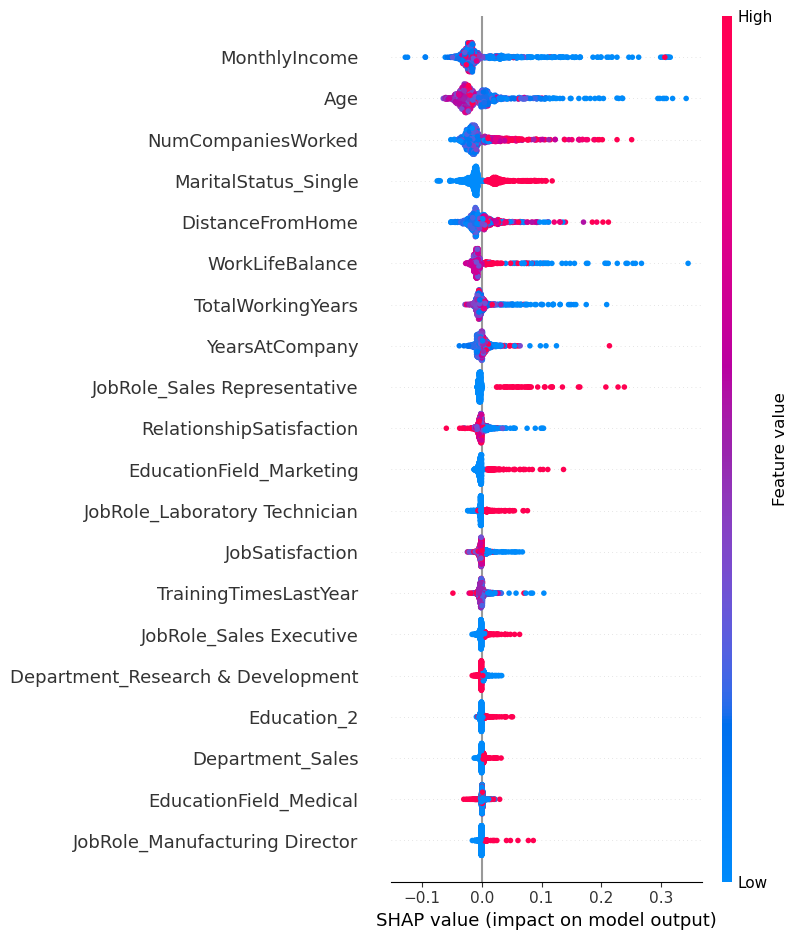

In [26]:
# 각 변수별 shapley value 분포를 한눈에 보여줍니다.
shap.summary_plot(shap_values1, x_train)

##### ② 특정 관점으로 Data point이 Shap Value 정렬

In [27]:
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, x_train)

##### ③ 특정 변수 값과 변수의 shap value 간의 관계

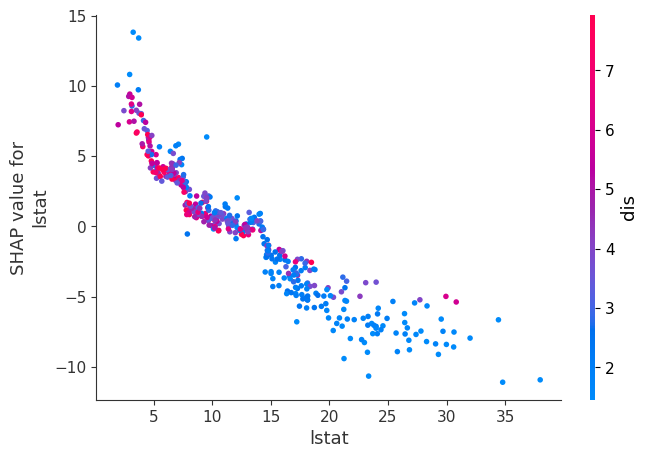

In [34]:
shap.dependence_plot('lstat', shap_values1, x_train)

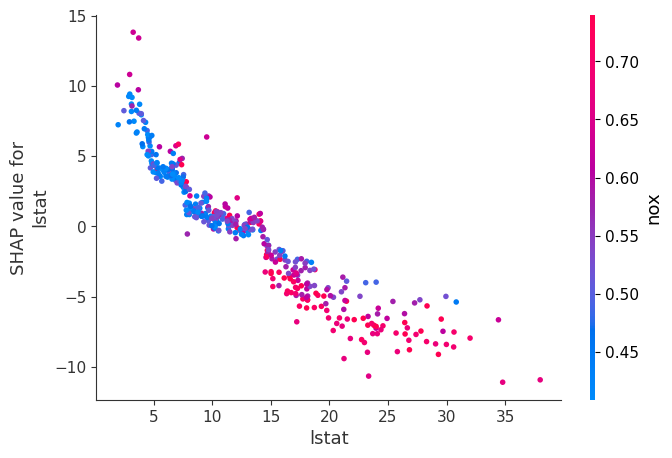

In [35]:
shap.dependence_plot('lstat', shap_values1, x_train, interaction_index = 'nox')

### 2. KernelExplainer

##### ① SVM 모델링

In [39]:
model2 = SVR()
model2.fit(x_train_s, y_train)

SVR()

###### ② Shap Value 만들기
* shap.KernelExplainer(모델.**predict**, x)
    * TreeExplainer는 그냥 모델을 넣었지만, KernelExpaliner는 모델.**predict**로 넣어야 한다.
* 데이터를 줄여서 10건만 수행한다.

In [40]:
explainer2 = shap.KernelExplainer(model2.predict, x_train_s)

# 10건만 줄여서 수행합니다.
shap_values2 = explainer2.shap_values(x_train_s[:10])

Using 404 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
shap_values2

array([[ 0.10519098,  0.14891478,  0.45284477, -0.09853   ,  0.30528773,
        -0.76373345,  0.76867214, -1.12042348, -0.24937668,  0.79325872,
         0.86705465, -0.18084915],
       [-0.38426078, -0.19900456, -0.4702012 , -0.17822418, -0.27529121,
        -1.89634627, -0.96095982,  0.38803203,  0.57213613, -0.77443581,
        -0.57916836, -0.02165694],
       [ 0.08989   , -0.310926  ,  0.11154573, -0.16985956,  0.14501779,
        -0.42122621, -0.90248252,  0.12193651, -0.15592721,  0.4111937 ,
        -1.32689913, -2.23056659],
       [ 0.14383612, -0.30378999, -0.28535272, -0.11059433,  0.45018799,
        -0.13557685,  0.6375002 , -0.30713439, -0.21775088, -0.08213998,
        -0.23173313,  0.19886664],
       [ 0.13016115, -0.30226134,  0.76934241, -0.08562412,  0.29529922,
        -1.58202538, -0.52549913,  0.66800628, -0.06139716,  0.61529849,
         1.08559674, -0.54731135],
       [ 0.16396894, -0.21842743, -0.32806751, -0.1578988 , -0.12364287,
        -0.45017486, -

In [55]:
# shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2, x_train_s[:10])

In [56]:
# shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0], x_train.iloc[0])

### 3. DeepExplainer

##### ① DL 모델링

In [44]:
# 간단한 DL 모델을 생성합니다.
nfeatures = x_train.shape[1]

clear_session()

model3 = Sequential([Dense(4, input_shape = (nfeatures,), activation = 'relu'),
                     Dense(1)])

model3.compile(optimizer='adam', loss='mse')

history = model3.fit(x_train_s, y_train,
                     epochs = 100, batch_size = 64,
                    validation_split=0.2).history

Epoch 1/100
6/6 [==============================] - 1s 59ms/step - loss: 542.8778 - val_loss: 580.8514
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 542.1525 - val_loss: 580.0718
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 541.4068 - val_loss: 579.2785
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 540.6091 - val_loss: 578.4523
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 539.7773 - val_loss: 577.5790
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 538.8945 - val_loss: 576.6564
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 537.9418 - val_loss: 575.6844
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 536.9545 - val_loss: 574.6613
Epoch 9/100
6/6 [==============================] - 0s 15ms/step - loss: 535.8946 - val_loss: 573.5396
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 534.7217 

##### ② Shap Value 만들기

* DeepExplainer로 부터 shap_values를 추출하면
    * **리스트 안에 np.array로 값이 저장**된다.(아니..왜...)
    * 그래서 이를 사용하려면 값을 뽑아내서(리스트[0])로 사용해야 한다.

In [45]:
explainer = shap.DeepExplainer(model3, x_train_s)
shap_values = explainer.shap_values(x_train_s)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [46]:
shap_values

[array([[-0.06265035,  0.13819355, -0.5543205 , ..., -0.52696883,
         -0.47739405,  0.02001713],
        [ 0.15763425, -0.15934079,  0.61513211, ...,  0.75239979,
          0.44958993,  0.01382184],
        [-0.03765804, -0.15934079, -0.31967913, ..., -0.33340006,
          0.66770381,  0.37573017],
        ...,
        [-0.02510112, -0.15934079,  0.61513211, ...,  0.75239979,
          0.44958993,  0.01433811],
        [-0.06133374, -0.15934079,  1.32374906, ..., -0.693317  ,
          0.14968335,  0.09023045],
        [-0.05161618,  0.12402525, -0.71106094, ..., -0.46345408,
         -1.51343498, -0.13486518]])]

In [47]:
# 리스트에서 값을 빼내기
shap_values = shap_values[0]

In [48]:
ev = explainer.expected_value.numpy()

In [57]:
# shap.initjs()
shap.force_plot(ev, shap_values, x_train)

In [58]:
# shap.initjs()
shap.force_plot(ev, shap_values[0], x_train.iloc[0])

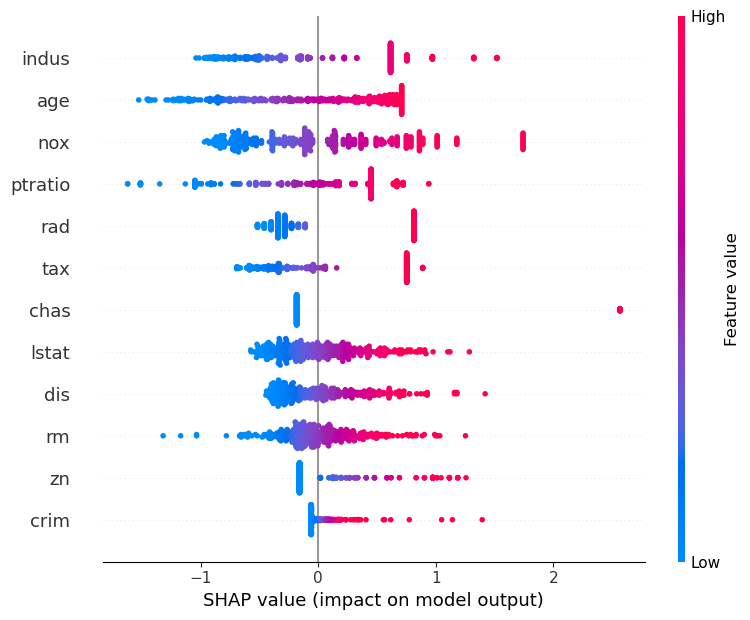

In [51]:
shap.summary_plot(shap_values, x_train)